# **핸즈온 Ch.3 분류**

p.127-154

**[3.1 MNIST]**


In [1]:
#MNIST 데이터셋 내려받는 코드
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

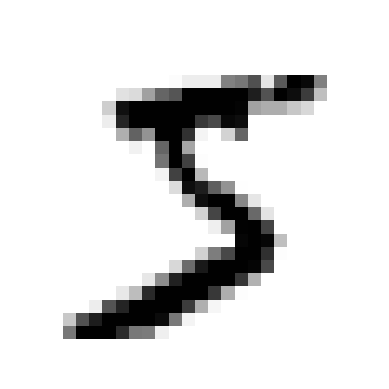

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
#그림 상 숫자 5로 보이는데, 실제 레이블 확인하기
y[0]

'5'

In [6]:
#y를 정수로 변환
import numpy as np
y = y.astype(np.uint8)

데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어놓아야 함.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**[3.2 이진 분류기 훈련]**
- 이진 분류기: 두 개의 클래스를 구분할 수 있음

In [8]:
#분류 작업을 위한 타깃 벡터 만들기
y_train_5 = (y_train == 5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

In [9]:
#SGDClassifier 클래스 사용해 확률적 경사 하강법 적용
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

- SGDClassifier: 매우 큰 데이터셋을 효율적으로 처리하는 장점을 가짐.
  - 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문

In [10]:
#숫자 5의 이미지 감지하기
sgd_clf.predict([some_digit])

array([ True])

**[3.3 성능 측정]**

3.3.1 교차 검증을 위한 정확도 측정
- 다음 코드는 사이킷런의 cross_val_score() 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력함.
- StratifiedKFold: 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행함.
  - 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듬. 그런 뒤, 올바른 예측의 수를 세어 정확한 예측의 비율을 출력함.

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


- k 교차 검증: 훈련 세트를 k개 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용함.

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

-> 모든 교차 검증 폴드에 대해 정확도가 95% 이상임.

In [13]:
#모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기 만들어 비교하기
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

-> 정확도가 90% 이상으로 나옴.

-> 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌.(특히 불균형한 데이터셋을 다룰 때)

3.3.2 오차 행렬
- 오차 행렬: 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것
  - 행: 실제 클래스, 열: 예측 클래스
- cross_val_predict(): k 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측 반환함.

  -> 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 됨.


In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 1행 1열(53892): 5가 아닌 이미지를 5가 아니라고 맞게 분류 -> 진짜 음성(true negative_
- 1행 2열(687): 5가 아닌 이미지를 5라고 잘못 분류 -> 거짓 양성(false positive)
- 2행 1열(1891): 5 이미지를 5가 아니라고 잘못 분류 -> 거짓 음성(false negative)
- 2행 2열(3530): 5 이미지를 5라고 맞게 분류 -> 진짜 양성(true positive)

In [18]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

3.3.3 정밀도와 재현율
- 정밀도(양성 예측의 정확도): TP/(TP+FP)
- 재현율(분류기가 정확하게 감지한 양성 샘플의 비율, 민감도, 진짜 양성 비율): TP/(TP+FN)


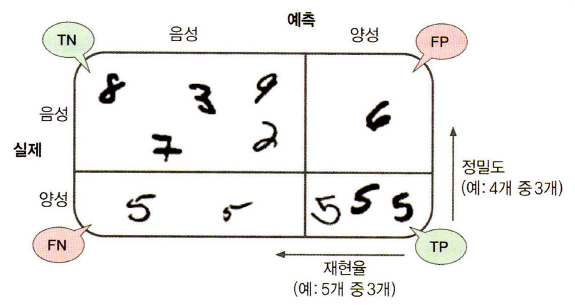



In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

- F1 점수 : 정밀도와 재현율의 조화 평균
  - f1_score() 함수 호출하기
  - 정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높음.
    - 항상 바람직한 것은 아님. 상황에 따라 정밀도와 재현율의 중요도가 달라짐.

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

3.3.4 정밀도/재현율 트레이드오프
- 정밀도/재현율 트레이드오프 : 정밀도를 올리면 재현율이 줄고, 정밀도를 줄이면 재현율이 올라감.
  - 분류기는 결정 함수를 사용하여 각 샘플의 점수를 계산하고 임곗값과 비교하여 클래스에 할당함.
  - 결정 임곗값에 따라 정밀도와 재현율이 달라짐.
  - 사이킷런에서 임곗값을 직접 지정할 수는 없지만, 예측에 사용된 점수는 확인할 수 있음: predict() 매서드 대신에 decision_function() 메서드 호출하기

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [23]:
#임곗값 높이기
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

-> 임곗값을 높이면 재현율이 줄어듬.
- 적절한 임곗값을 구하기 위해선 먼저 cross_val_predict() 함수를 이용해 훈련 세트에 있는 모든 점수를 구하기

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

-> 이 점수로 precision_recall_curve() 함수를 사용해 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있음

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44247 (\N{HANGUL SYLLABLE GYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packag

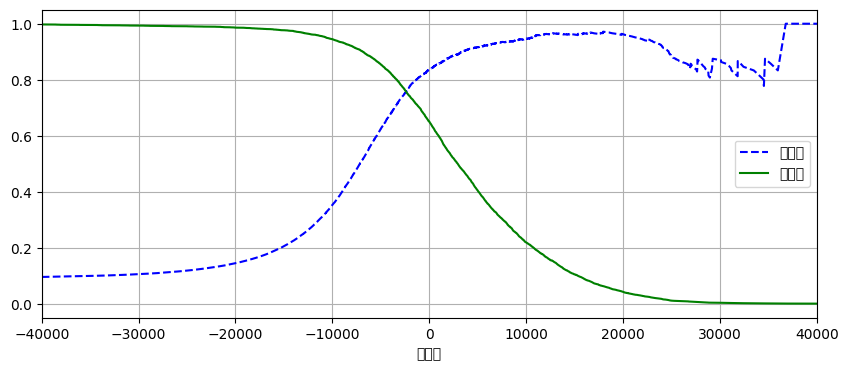

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.figure(figsize=(10,4))
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
  plt.xlabel("임곗값")
  plt.xlim(-40000, 40000)
  plt.legend()
  plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

- 파란색: 정밀도
- 초록색: 재현율

- 재현율 80% 근처에서 정밀도가 급격히 줄어듬 -> 정밀도/재현율 트레이드오프로 선택하기
- 최소한 90% 정밀도가 되는 가장 낮은 임계값 찾기

In [27]:
#np.argmax(): 최댓값의 첫 번째 인덱스를 반환
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

3.3.5 ROC 곡선
- ROC 곡선
  - 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR, 재현율)의 곡선
  - 민감도(재현율)에 대한 (1-특이도) 그래프

In [31]:
#roc_curve() 함수 이용해 여러 임곗값에서 TPR, FPR 계산하기
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

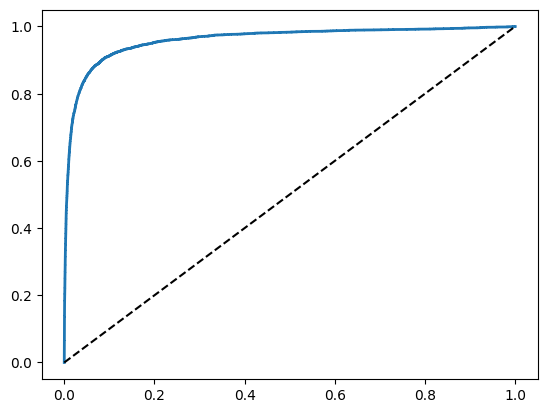

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--') # 대각 점선

plot_roc_curve(fpr, tpr)
plt.show()

-> 좋은 분류기는 점선에서 최대한 멀리 떨어져 있어야 함.

- 곡선 아래의 면적(AUC)을 측정하면 분류기들을 비교할 수 있음.
  - 완벽한 분류기: AUC=1
  - 완전한 랜덤한 분류기: AUC=0.5

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

- RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교하기
  - predict_proba(): 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환함.

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [35]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용합니다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

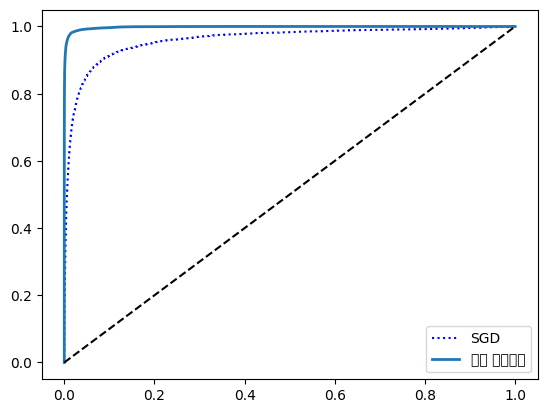

In [36]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

-> RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까움, ROC AUC점수도 훨씬 높음.

**[3.4 다중 분류]**
- 다중 분류기(다항 분류기): 둘 이상의 클래스 구별 가능
- OvR 전략(OvA): 이진 분류기 여러 개를 훈련시켜 클래스를 분류, 각 분류기의 결정 점수 중에서 가장 높은 것은 클래스로 선택
  - 대부분의 이진 분류 알고리즘에서 선호
- OvO 전략: 각 숫자의 조합마다 이진 분류기를 훈련시키기
  - SVM과 같은 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호

In [38]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train[:2000], y_train[:2000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [39]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 3.79297828,  0.72949369,  6.06184129,  8.29800527, -0.29383983,
         9.30157597,  1.74723215,  2.77365456,  7.20601456,  4.82245092]])

-> 가장 높은 점수가 클래스 5에 해당하는 값

In [40]:
np.argmax(some_digit_scores)

5

In [41]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [42]:
svm_clf.classes_[5]

5

- 사이킷런에서 OvO나 OvR: OneVsOneClassifier, OneVsRestClassifier

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
sgd_clf.fit(X_train[:2000], y_train[:2000])
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-1704540.26918897, -1683382.42678916, -2594122.50571131,
         -145667.7337014 , -3270741.36924448,    -4883.95058744,
        -3420127.24409032, -1846510.16554943, -1328858.01006284,
        -2043246.17459117]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

**[3.5 에러 분석]**
- 만들어진 에러의 종류를 분석하는 것으로 모델의 성능을 향상시키기

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

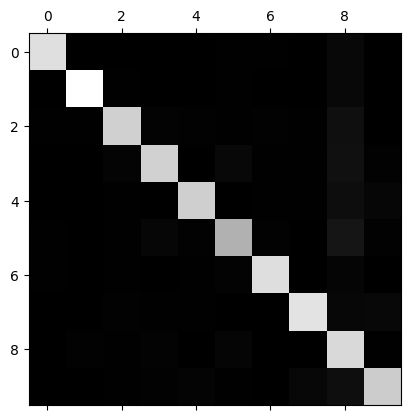

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

-> 숫자 5는 다른 숫자 보다 조금 더 어두어 보임: 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻

In [ ]:
#오차 행렬의 각 값에 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교하기
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

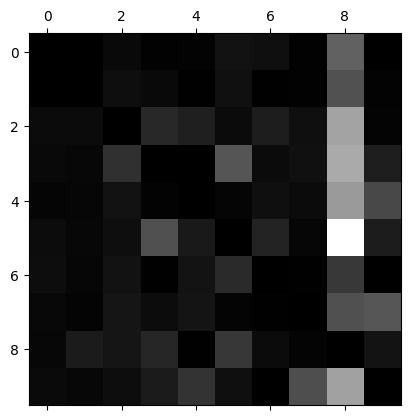

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 클래스 8의 열이 상당히 밝음: 많은 이미지가 8로 잘못 분류되었음을 암시함.
- 클래스 8의 행: 실제 8이 8로 적절히 분류되었음.
- 3과 5가 많이 혼동되고 있음.(오차 행렬은 반드시 대칭인 것은 아님.)

In [ ]:
import matplotlib.pyplot as plt
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다.
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

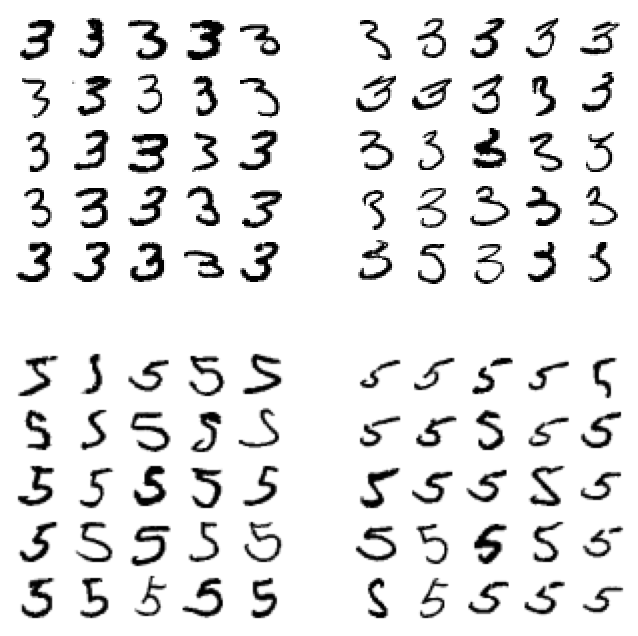

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- 왼쪽 5X5 블록 두 개: 3으로 분류된 이미지
- 오른쪽 5X5 블록 두 개: 5로 분류된 이미지
- 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산함 -> 3과 5는 몇개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 됨.
  - 에러를 줄이는 방법: 이미지를 중앙에 위치시키기고 회전되어 있지 않도록 전처리하기

**[3.6 다중 레이블 분류]**
- 다중 레이블 분류: 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
#모든 레이블에 대한 F1 점수의 평균 계산
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

- average="weighted" : 레이블에 클래스의 지지도(타깃 레이블에 속한 샘플 수)를 가중치로 주는

**[3.7 다중 출력 분류]**
- 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것(값을 두 개 이상 가질 수 있음.)
- 이미지에서 잡음을 제거하는 시스템 만들기

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

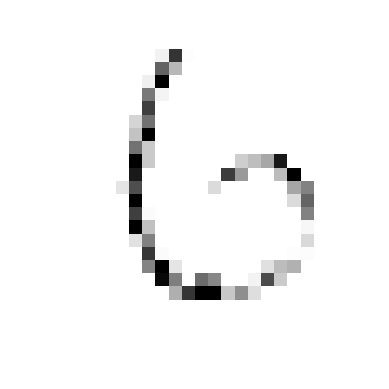

In [ ]:
some_index = 100
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)